In [1]:
from test import autoencoder_plus_weightnet_trainer, autoencoder_plus_kmeans_plus_weightnet_trainer, loadData
import torch.multiprocessing as mp
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
from lib.train import InterpretableTrainer, Trainer
from torch.utils.data import Dataset, DataLoader, TensorDataset
from lib.model import Switch, Weight, apply_linear
from lib.utility import logit_elementwise_loss
from lib.utility import plotDecisionSurface, to_var, to_np, check_nan, onehotize, to_cuda
from lib.utility import genCovX
from lib.model import WeightIndependent
from itertools import product
import os
from sklearn.externals import joblib
from lib.parallel_run import map_parallel
from collections import defaultdict
from lib.utility import reportAcc, reportAuc, loadData
import glob, os
import pandas as pd
from test import deep_locally_linear_trainer, autoencoder_plus_kmeans_plus_weightnet_trainer
from test import autoencoder_plus_weightnet_trainer, kmeans_plus_weightnet_trainer, mixture_of_expert_trainer
from test import weightnet_trainer, mlp_trainer, linear_trainer
from test import poskmeans_plus_weightnet_trainer

# discrete clusters

## within cluster has 2 classes

Train
10 tasks


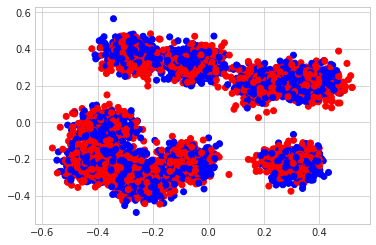

Validation


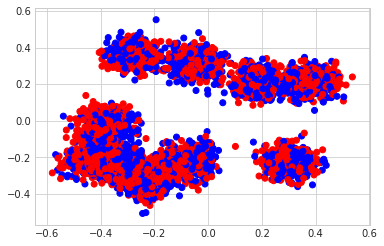

Test


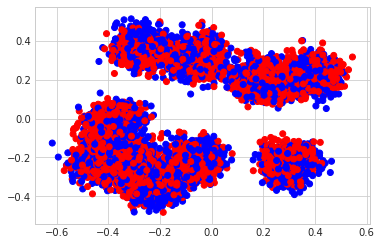

In [499]:
# island of lines
# randomly generate centers, then generate gaussian around that center, 

def build_islands(dim=2, n_island=None, n_per_island=None, scale=0.05, noise=0):
    assert noise >= 0 and noise <= 1, "noise is a probability of flipping signs"
    if n_island is None:
        n_island = np.random.randint(2,20)
    print(n_island, 'tasks')
    
    Theta = []
    X = []
    Y = []
    centers = np.random.rand(n_island, dim) - 0.5
    for i in range(n_island):
        if n_per_island is None:
            n_per_island = np.random.randint(dim * 5, dim * 20)
        center = centers[i]
        x = np.random.randn(n_per_island, dim) * scale + center
        plt.scatter([center[0]], [center[1]], marker='*', color='brown')
        X.append(x)
        # generate classifier that passes through the center
        theta = np.random.rand(dim) - 0.5
        theta = theta / np.sqrt((theta**2).sum()) # normalize
        b = - theta.dot(center)
        Theta.append([dim, center, scale, noise, n_per_island, theta, b])

        y = (x.dot(theta) + b >= 0) * 2 -1
        flip_signs = np.random.choice([-1,1], size=y.shape, p=[noise, 1-noise])
        y = y * flip_signs

        Y.append(y)
    return np.vstack(X), np.hstack(Y), Theta

def build_test_islands(Theta, enlarge=1):
    X = []
    Y = []
    test_theta = []
    for dim, center, scale, noise, n_per_island, theta, b in Theta:
        n_per_island = n_per_island * enlarge
        x = np.random.randn(n_per_island, dim) * scale + center
        plt.scatter([center[0]], [center[1]], marker='*', color='brown')
        X.append(x)

        y = (x.dot(theta) + b >= 0) * 2 -1
        flip_signs = np.random.choice([0,1], size=y.shape, p=[noise, 1-noise])
        y = y * flip_signs

        Y.append(y)
        local_theta = []
        for _ in range(n_per_island):
            local_theta.append(list(theta) + [b])
        test_theta.append(np.array(local_theta))
    return np.vstack(X), np.hstack(Y), np.vstack(test_theta)

def recover_subtasks(X, Y, Theta):
    '''Theta comes from build training data'''
    tasks = []
    i = 0
    for _, _, _, n_per_island, _, _ in Theta:
        x = X[i: i+n_per_island]
        y = Y[i: i+n_per_island]
        i = i + n_per_island
        tasks.append((x, y))
    return tasks
    
def plotData(X, y):
    plt.scatter(X[:,0], X[:,1], c=list(map(lambda x: 'b' if x==-1 else 'r', y)))
    plt.show()

ndim = 50
noise = 0.05
n_per_island = 500 #None
n_island = 10 #None
print('Train')
X, Y, theta = build_islands(ndim, noise=noise, n_per_island=n_per_island, n_island=n_island)
n_islands = len(Theta)
plotData(X, Y)

print('Validation')
Xval, Yval, val_theta = build_test_islands(theta, 1)
plotData(Xval, Yval)

print('Test')
Xtest, Ytest, test_theta = build_test_islands(theta, 2)
plotData(Xtest, Ytest)

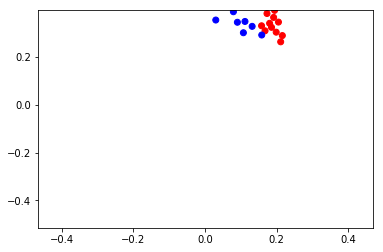

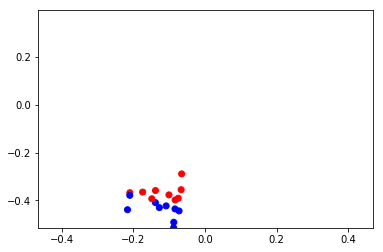

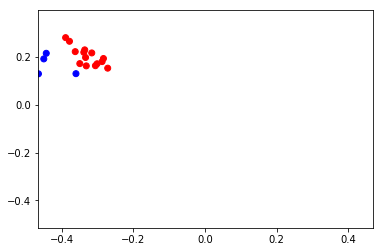

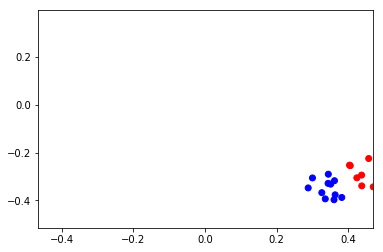

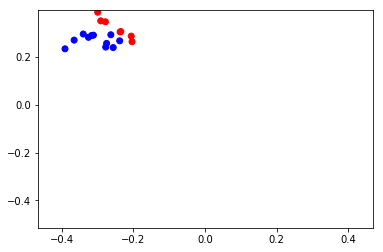

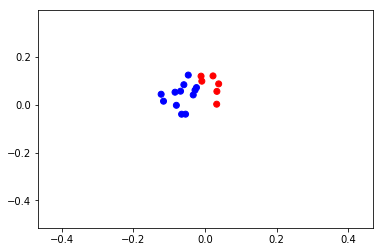

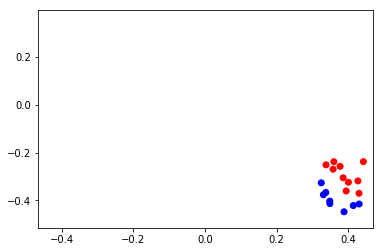

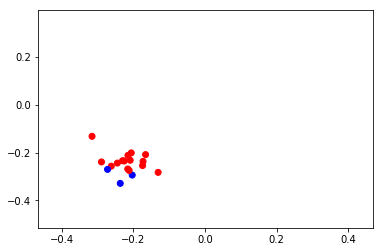

In [20]:
xmin, xmax, ymin, ymax = X[:,0].min(), X[:,0].max(), X[:,1].min(), X[:,1].max()
for x, y in recover_subtasks(X, Y, Theta):
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plotData(x, y)

## within cluster has two separated classes

Train
1 tasks


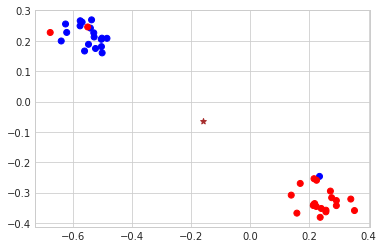

Validation


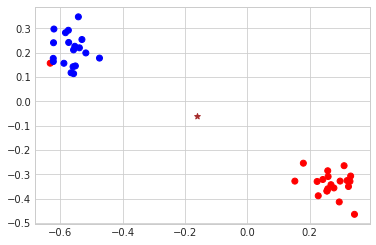

Test


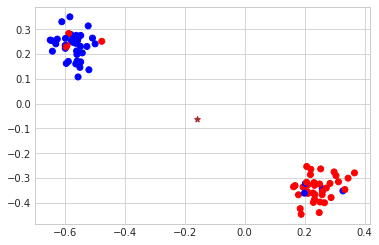

In [548]:
# island of lines
# randomly generate centers, then generate gaussian around that center, 

def build_islands(dim=2, n_island=None, 
                  n_per_island=None, scale=0.05, nstd=10, noise=0):
    '''
    nstd: within cluster class separation by nstd standar deviations of the scale
    '''
    if n_island is None:
        n_island = np.random.randint(2,20)
    print(n_island, 'tasks')
    
    Theta = []
    X = []
    Y = []
    centers = np.random.rand(n_island, dim) - 0.5
    for i in range(n_island):
        if n_per_island is None:
            n_per_island = np.random.randint(dim * 3, dim * 10)

        center = centers[i]
        # generate classifier that passes through the center
        theta = np.random.rand(dim) - 0.5
        b = - theta.dot(center)

        # generate 2 centers
        centerpos = center + nstd * scale * theta / np.sqrt((theta**2).sum())
        centerneg = center - nstd * scale * theta / np.sqrt((theta**2).sum())
        
        xpos = np.random.randn(n_per_island, dim) * scale + centerpos
        xneg = np.random.randn(n_per_island, dim) * scale + centerneg
        x = np.vstack([xpos, xneg])

        plt.scatter([center[0]], [center[1]], marker='*', color='brown')
        X.append(x)

       
        # assign points
        Theta.append([dim, center, scale, n_per_island, nstd, noise, theta, b])
        y = (x.dot(theta) + b >= 0) * 2 -1
        flip_signs = np.random.choice([-1,1], size=y.shape, p=[noise, 1-noise])
        y = y * flip_signs


        Y.append(y)
    return np.vstack(X), np.hstack(Y), Theta

def build_test_islands(Theta, enlarge=1):
    X = []
    Y = []
    test_theta = []
    for dim, center, scale, n_per_island, nstd, noise, theta, b in Theta:
        n_per_island = n_per_island * enlarge
        # generate 2 centers
        centerpos = center + nstd * scale * theta / np.sqrt((theta**2).sum())
        centerneg = center - nstd * scale * theta / np.sqrt((theta**2).sum())
        
        xpos = np.random.randn(n_per_island, dim) * scale + centerpos
        xneg = np.random.randn(n_per_island, dim) * scale + centerneg
        x = np.vstack([xpos, xneg])
        
        plt.scatter([center[0]], [center[1]], marker='*', color='brown')
        X.append(x)
        y = (x.dot(theta) + b >= 0) * 2 -1
        flip_signs = np.random.choice([-1,1], size=y.shape, p=[noise, 1-noise])
        y = y * flip_signs

        
        Y.append(y)
        local_theta = []
        for _ in range(n_per_island * 2): # b/c 2 n_per_islands are generated
            local_theta.append(list(theta) + [b])
        test_theta.append(np.array(local_theta))
    return np.vstack(X), np.hstack(Y), np.vstack(test_theta)

def plotData(X, y):
    plt.scatter(X[:,0], X[:,1], c=list(map(lambda x: 'b' if x==-1 else 'r', y)))
    plt.show()

ndim = 2
n_island = 1
n_per_island = 20 # None
noise = 0.05

print('Train')
X, Y, theta = build_islands(ndim, n_island=n_island, n_per_island=n_per_island, noise=noise)
n_islands = len(Theta)
plotData(X, Y)

print('Validation')
Xval, Yval, val_theta = build_test_islands(theta, 1)
plotData(Xval, Yval)

print('Test')
Xtest, Ytest, test_theta = build_test_islands(theta, 2)
plotData(Xtest, Ytest)

# contigous dataset

## 1d data

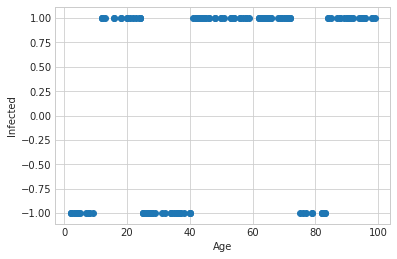

In [205]:
# 1 d data
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def build_age_bands(n_islands=5, n_per_islands=30, centers=None):
    upper = 100
    # spread points from 0, 100
    n = n_islands * n_per_islands
    if centers is None:
        centers = np.random.choice(list(range(upper)), n_islands, replace=False)
        centers.sort()
    # draw n points uniformly from 0 to 100
    X = np.random.choice(list(range(upper)), n).reshape(n, 1)
    # assign y according to distance to centers
    distance_to_center = X - centers
    assignment = np.abs(distance_to_center).argmin(1)
    # for odd points, flip left and right
    odd_cols = list(range(1,n_islands,2))
    distance_to_center[:,odd_cols] = -distance_to_center[:,odd_cols]
    # if the index point is negative then assign -1, else 1
    Y = (distance_to_center[np.arange(n), assignment] > 0) * 2 - 1
    # y = ax+b, get true theta (a,b), fix a to be +1 or -1
    a = np.ones(n_islands)
    a[odd_cols] = -1
    b = -a * np.array(centers)
    Theta = np.vstack((a, b)).T
    # assign for each point its true theta
    theta = [Theta[i] for i in assignment]
    return X, Y, np.array(theta)

centers = [10, 25, 40, 74, 83]
n_islands = len(centers)

ndim = 1

X, Y, theta = build_age_bands(centers=centers)
plt.scatter(X.ravel(), Y)
plt.xlabel('Age')
plt.ylabel('Infected')
plt.show()


Train


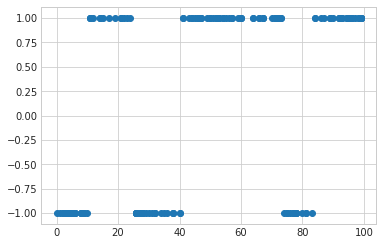

Validation


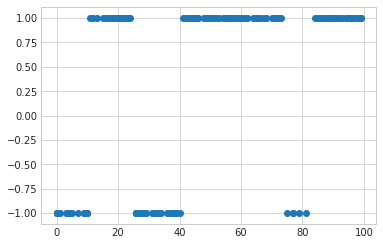

Test


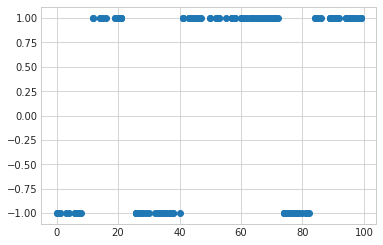

In [206]:
print('Train')
X, Y, theta = build_age_bands(centers=centers)
plt.scatter(X.ravel(), Y)
plt.show()

print('Validation')
Xval, Yval, val_theta = build_age_bands(centers=centers)
plt.scatter(Xval.ravel(), Yval)
plt.show()

print('Test')
Xtest, Ytest, test_theta = build_age_bands(centers=centers)
plt.scatter(Xtest.ravel(), Ytest)
plt.show()


In [575]:
a = np.arange(10)
np.tile(a, (2, 1))

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

# combination of contiguous data and discrete clusters data

Train
3 clusters
6 tasks


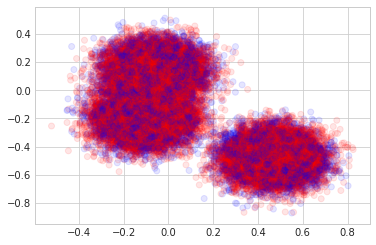

Validation


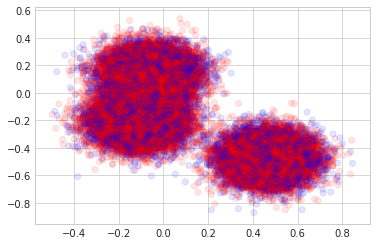

Test


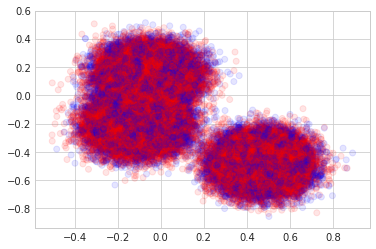

In [262]:
def build_islands(dim=2, n_island=None, 
                  n_per_island=None, scale=0.05, 
                  nstd=1, noise=0,
                  n_continuous_regions_per_island=None,
                  size=1):
    '''
    nstd: within cluster class separation by nstd standard deviations of the scale
    '''
    if n_island is None:
        n_island = np.random.randint(2,20)
    if n_continuous_regions_per_island is None:
        n_continuous_regions_per_island = np.random.randint(1,5)
    print(n_island, 'clusters')
    print(n_island * n_continuous_regions_per_island, 'tasks')
    
    Theta = []
    X = []
    Y = []
    centers = np.random.rand(n_island, dim) - 0.5
    for i in range(n_island):
        if n_per_island is None:
            n_per_island = np.random.randint(dim * 50, dim * 100)

        center = centers[i]
        # generate classifier that passes through the center
        theta = np.random.rand(dim) - 0.5

        x = []
        bs = []
        step_direction = theta / np.sqrt((theta**2).sum())
        for step in range(n_continuous_regions_per_island):
            center_curr = center + step * nstd * scale * step_direction
            b = -theta.dot(center_curr)
            bs.append(b)
            
            plt.scatter([center_curr[0]], [center_curr[1]], marker='*', color='black', s=100)

            # todo: assign distribution of x differently
#             x_inside = np.random.randn(n_per_island, dim) * scale + center_curr
#             x.append(x_inside)
        
#         x = np.vstack(x)

        middle = (n_continuous_regions_per_island - 1) / 2
        if middle == 0:
            radius = scale * nstd * size
        else:
            radius = scale * nstd * middle * size
        real_center = center + middle * nstd * scale * step_direction
        x = np.random.randn(n_per_island * n_continuous_regions_per_island, dim) * radius + real_center
    
        X.append(x)
        
        # assign points to its closest classifier
        points = x.dot(theta) # projection on to theta
        n = points.shape[0]
        points = points.reshape(n, 1)
        
        distance_to_center = points + bs
        assignment = np.abs(distance_to_center).argmin(1)
        # for odd points, flip left and right
        odd_cols = list(range(1,n_continuous_regions_per_island,2))
        distance_to_center[:,odd_cols] = -distance_to_center[:,odd_cols]
        # if the index point is negative then assign -1, else 1
        y = (distance_to_center[np.arange(n), assignment] > 0) * 2 - 1
        # add noise to y label
        flip_signs = np.random.choice([-1,1], size=y.shape, p=[noise, 1-noise])
        y = y * flip_signs
        Y.append(y)

        Theta.append([dim, center, scale, n_per_island, nstd, noise, theta, bs, size])

    return np.vstack(X), np.hstack(Y), Theta

def build_test_islands(Theta, enlarge=1):
    X = []
    Y = []
    test_theta = []
    for dim, center, scale, n_per_island, nstd, noise, theta, bs, size in Theta:
        n_per_island = n_per_island * enlarge
        n_continuous_regions_per_island = len(bs)
        
        x = []
        step_direction = theta / np.sqrt((theta**2).sum())
        for step, b in enumerate(bs):
            center_curr = center + step * nstd * scale * step_direction
            # todo: assign distribution of x differently
#             x_inside = np.random.randn(n_per_island, dim) * scale + center_curr
#             plt.scatter([center_curr[0]], [center_curr[1]], marker='*', color='black', s=100)
#             x.append(x_inside)
            
#         x = np.vstack(x)
        
        middle = (n_continuous_regions_per_island - 1) / 2
        if middle == 0:
            radius = scale * nstd * size
        else:
            radius = scale * nstd * middle * size
        real_center = center + middle * nstd * scale * step_direction
        x = np.random.randn(n_per_island * n_continuous_regions_per_island, dim) * radius + real_center

        
        X.append(x)
            
        # assign points to its closest classifier
        points = x.dot(theta) # projection on to theta
        n = points.shape[0]
        points = points.reshape(n, 1)
        
        distance_to_center = points + bs
        assignment = np.abs(distance_to_center).argmin(1)
        # for odd points, flip left and right
        odd_cols = list(range(1,n_continuous_regions_per_island,2))
        distance_to_center[:,odd_cols] = -distance_to_center[:,odd_cols]
        # if the index point is negative then assign -1, else 1
        y = (distance_to_center[np.arange(n), assignment] > 0) * 2 - 1
        # add noise to y label
        flip_signs = np.random.choice([-1,1], size=y.shape, p=[noise, 1-noise])
        y = y * flip_signs
        Y.append(y)
        
        Theta = np.tile(theta, (n_continuous_regions_per_island, 1))
        Theta = np.hstack([Theta, np.array(bs).reshape(len(bs), 1)])
        Theta[odd_cols] = - Theta[odd_cols]
        
        if Theta.shape[1] == 3:
            print(Theta)
            for t in Theta:
                # a x + b y + c = 0
                # y = (-a x - c) / b
                a,b,c = t
                def line(x):
                    return (- a * x - c) / b
                x_in = np.array([x[:,0].min(), x[:,0].max()])
                plt.plot(x_in, line(x_in))
                
        test_theta.append([Theta[i] for i in assignment])

    return np.vstack(X), np.hstack(Y), np.vstack(test_theta)

def plotData(X, y):
    plt.scatter(X[:,0], X[:,1], c=list(map(lambda x: 'b' if x==-1 else 'r', y)), alpha=0.1)
    plt.show()

ndim = 100
nstd = 2
n_island = 3
n_continuous_regions_per_island = 2

size = 1 # how sparse the region has to be
scale=0.1
n_per_island = None
noise = 0.05

print('Train')
X, Y, theta = build_islands(ndim, n_island=n_island, nstd=nstd,
                            n_per_island=n_per_island, noise=noise, scale=scale,
                            n_continuous_regions_per_island=n_continuous_regions_per_island, 
                            size=size)
n_islands = len(theta)
plotData(X, Y)

print('Validation')
Xval, Yval, val_theta = build_test_islands(theta, 1)
plotData(Xval, Yval)

print('Test')
Xtest, Ytest, test_theta = build_test_islands(theta, 2)
plotData(Xtest, Ytest)

# saving and loading data

In [264]:
dataname = #'ctn_100d_6tasks_0.05noise'
#'ctn_2d_3tasks_0.05noise'
#'ctn_100d_3cluster_9tasks_0.05noise_2'
#'ctn_100d_4tasks_0.05noise'
#'ctn_discrete_100d_10tasks_0.05noise'
#'ctn_discrete_30d_6tasks_0.05noise'
#'ctn_discrete_2d_3tasks_0noise'
#'50d-10tasks-0.05noise'
#'50d-3tasks-0.05noise'
#'10d-3tasks-0.05noise' #'2d-2tasks-0.05noise'#'100d-14tasks-0.05noise'
#'10d-1-2stars0' #'1d-band-task'#'150d-15-tasks'#'100d-5-tasks' #'100d-7-tasks' #'100d-8-tasks' #'100d-12-tasks'#'100d-9-tasks'
#'100d-4tasks'#'100d-6-cluster'# note: please comment this every run so that files are not covered
joblib.dump([X, Y, theta, 
             Xval, Yval, val_theta, 
             Xtest, Ytest, test_theta, 
             ndim, n_islands], 'data/%s.pkl' % dataname)
print(X.shape)

(48186, 100)


In [774]:
dataname = 'ctn_100d_5cluster_25tasks_0.05noise'
#'150d-15-tasks'
#'100d-5-tasks' #'30d-17-tasks'#'100d-9-tasks'#'data/100d-4tasks' #'100d-6-cluster' 
X, Y, Theta, \
Xval, Yval, val_theta,\
Xtest, Ytest, test_theta,\
ndim, n_islands = joblib.load('data/%s.pkl' % dataname)

print('train shape:', X.shape, 'n_islands:', n_islands, 'ndim:', ndim)
print('%.2f%% positive examples' % ((Y==1).sum() / len(Y) * 100))

train shape: (48800, 100) n_islands: 11 ndim: 100
50.06% positive examples


In [4]:
print(dataname)
train_data, test_data, ndim, n_islands, test_theta = loadData(dataname)

100d-9-tasks
train shape: (84195, 100) n_islands: 9 ndim: 100
done loading data


baselines

1. a network that has comparable number of parameters that run on this data
2. first cluster, then classify

other things needed to do:
1. try the cosine metric on triangle and square graph and make sure it is near 1
2. try to figure out how to increase gpu memory usage

more ideas:
to force connected partition of input, we need hidden size the same as input size (in this case, undercomplete matrix and overcomplete matrix may merge different regions). But overcomplete matrix gives more power to the network, we want the cluster surface to be smooth, that is the input gradient should be close to zero. We could thus penalyze input gradient, which should give larger regions

1. for switch net, set hidden layer size the same as input size
2. todo: if not work, try to penalyze input gradient for switchnet



# find the input gradient distribution so that I know how many are near 0

In [222]:
dataname = '100d-14tasks-0.05noise'
t = getTrainer('nonlinear_models/heter/100d-14tasks-0.05noise/mlp/lr0.001/bs1000/7G2JRP.pt',
               'mlp', dataname, 100, 14)
test_data, test_theta, ndim, n_islands = loadData(dataname, get_test=True)

for x, _ in test_data:
    x = to_var(x)
    x.requires_grad = True
    y = t.forward(x)
    y.sum().backward()
    theta = x.grad
    b = -(theta*x).sum(1).view(-1,1)
    theta = torch.cat([theta, b], dim=1)
    break

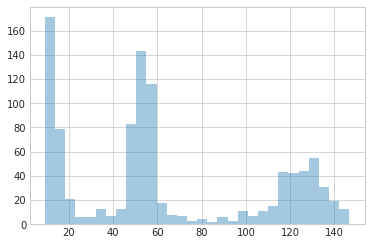

In [223]:
sns.distplot(to_np(torch.sqrt((theta * theta).sum(1))), bins=30, kde=False)
plt.show()

In [225]:
dataname = 'ctn_2d_3tasks_0.05noise'
t = getTrainer('nonlinear_models/heter/ctn_2d_3tasks_0.05noise/mlp/lr0.001/bs1000/9Vmw3l.pt',
               'mlp', dataname, 2, 3)
test_data, test_theta, ndim, n_islands = loadData(dataname, get_test=True)

for x, _ in test_data:
    x = to_var(x)
    x.requires_grad = True
    y = t.forward(x)
    y.sum().backward()
    theta = x.grad
    b = -(theta*x).sum(1).view(-1,1)
    theta = torch.cat([theta, b], dim=1)
    break

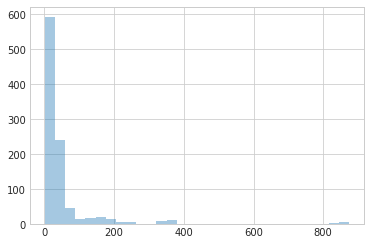

In [226]:
sns.distplot(to_np(torch.sqrt((theta * theta).sum(1))), bins=30, kde=False)
plt.show()

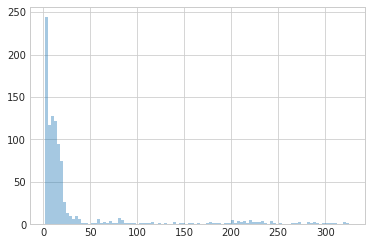

In [276]:
dataname = 'ctn_100d_6tasks_0.05noise'
t = getTrainer('nonlinear_models/heter/ctn_100d_6tasks_0.05noise/mlp/lr0.001/bs1000/2loMTd.pt',
               'mlp', dataname, 100, 6)
test_data, test_theta, ndim, n_islands = loadData(dataname, get_test=True)

for x, _ in test_data:
    x = to_var(x)
    x.requires_grad = True
    y = t.forward(x)
    y.sum().backward()
    theta = x.grad
    b = -(theta*x).sum(1).view(-1,1)
    theta = torch.cat([theta, b], dim=1)
    break
    
sns.distplot(to_np(torch.sqrt((theta * theta).sum(1))), bins=100, kde=False)
plt.show()

[0, 5]: cosine similarity 0.2396
[5, 10]: cosine similarity -0.2412
[10, 15]: cosine similarity 0.2155
[15, 20]: cosine similarity -0.0603
[20, 25]: cosine similarity -0.1669
[25, 30]: cosine similarity 0.4467
[30, 35]: cosine similarity 0.3238
[35, 40]: cosine similarity 0.2510
[40, 45]: cosine similarity 0.4261
[45, 50]: cosine similarity -0.2185
[50, 55]: cosine similarity 0.2192
[55, 60]: cosine similarity -0.7665
[60, 65]: cosine similarity 0.5616
[65, 70]: cosine similarity 0.7633
[70, 75]: cosine similarity 0.7743
[75, 80]: cosine similarity -0.0046
[80, 85]: cosine similarity 0.5344
[85, 90]: cosine similarity -0.9830
[90, 95]: cosine similarity 0.9960
[95, 100]: cosine similarity 0.3186


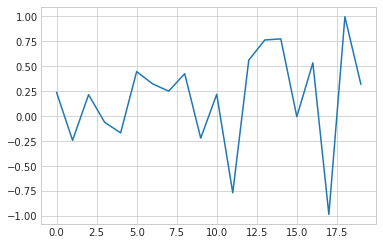

In [235]:
def constraint(low, window):

    def c(theta):
        norm2 = np.sqrt((theta * theta).sum()) 
        high = low + window
        return norm2 > low and norm2 < high
    
    return c 

window = 5
cosines = []
for low in range(0, 100, 5):
    cos = t.evaluate_subpopulation(test_theta, test_data, constraint(low, window))
    cosines.append(cos)
    print('[%d, %d]: cosine similarity %.4f' % (low, low+window, cos))

plt.plot(cosines)
plt.show()

# model evaluation

In [30]:
def loadModel(modelname):
    return torch.load(modelname)

def findSwitchFrequency(fname, method):
    if method in ['optweight']:
        if len(fname.split('/fq')) == 1:
            return 30
        return abs(int(fname.split('/fq')[-1].split('/')[0]))
    return 1

def findWd(fname, method):
    if len(fname.split('/wd')) == 1:
        return 0
    return float(fname.split('/wd')[-1].split('/')[0])

def findK(fname, method):
    if method in ['weight', 'mlp', 'linear']:
        return 0
    return float(fname.split('/k')[-1].split('/')[0])

def findAlpha(fname, method):
    if method in ['dlln','moe','optweight']:
        return float(fname.split('/a')[-1].split('/')[0])
    return None

def findLr(fname, method=None):
    return float(fname.split('/lr')[-1].split('/')[0])

def findBatchsize(fname, method=None):
    if len(fname.split('/bs')) == 1: 
        return 1000
    return int(fname.split('/bs')[-1].split('/')[0])    

def findCosine(fname, test_data, test_theta, method, trainer):
    if test_theta is None: return None
    return trainer.evaluate_subpopulation(test_theta, test_data)

def normalize_filename(fname, method):
    if method in ['auto_plus_weight', 'auto_plus_kmeans_plus_weight', 'kmeans_weight']:
        basename = os.path.basename(fname)
        prefix = os.path.dirname(os.path.dirname(fname))
        return os.path.join(basename, prefix)
    if method in ['dlln','moe','optweight']:
        return fname[:-9]
    return fname
    
    
def getTrainer(fname, method, dataname, D, K):
    if method == 'linear':
        return linear_trainer(dataname, D, K, model=loadModel(fname))
    if method == 'mlp':
        return mlp_trainer(dataname, D, K, model=loadModel(fname))
    elif method == 'auto_plus_kmeans_plus_weight':
        basename = os.path.basename(fname)
        prefix = os.path.dirname(os.path.dirname(fname))
        autoencoder = loadModel(prefix + '/0/' + basename)
        kmeans_clf = joblib.load(prefix + '/1/' + basename[:-3] + '.pkl')
        weight = loadModel(prefix + '/2/' + basename)        
        return autoencoder_plus_kmeans_plus_weightnet_trainer(dataname, D, K,
                                                              autoencoder=autoencoder,
                                                              weight=weight,
                                                              kmeans_clf=kmeans_clf)
    elif method == 'dlln':
        switch = loadModel(fname[:-9] + 'switch.pt')
        weight = loadModel(fname[:-9] + 'weight.pt')
        return deep_locally_linear_trainer(dataname, D, K, switch=switch,
                                           weight=weight)
    elif method == 'moe':
        switch = loadModel(fname[:-9] + 'switch.pt')
        weight = loadModel(fname[:-9] + 'weight.pt')
        return mixture_of_expert_trainer(dataname, D, K, switch=switch,
                                         weight=weight)
    elif method == 'optweight':
        switch = loadModel(fname[:-9] + 'switch.pt')
        weight = loadModel(fname[:-9] + 'weight.pt')
        return mixture_of_expert_trainer(dataname, D, K, switch=switch,
                                         weight=weight)    
    elif method == 'weight':
        return weightnet_trainer(dataname, D, K, weight=loadModel(fname))
    elif method == 'auto_plus_weight':
        basename = os.path.basename(fname)
        prefix = os.path.dirname(os.path.dirname(fname))
        autoencoder = loadModel(prefix + '/0/' + basename)
        weight = loadModel(prefix + '/1/' + basename)
        return autoencoder_plus_weightnet_trainer(dataname, D, K, 
                                                  autoencoder=autoencoder,
                                                  weight=weight)
    elif method == 'kmeans_weight':
        basename = os.path.basename(fname)
        prefix = os.path.dirname(os.path.dirname(fname))
        kmeans_clf = joblib.load(prefix + '/0/' + basename[:-3] + '.pkl')
        weight = loadModel(prefix + '/1/' + basename)        
        return kmeans_plus_weightnet_trainer(dataname, D, K,
                                             weight=weight,
                                             kmeans_clf=kmeans_clf)
    elif method == 'posk_weight':
        basename = os.path.basename(fname)
        prefix = os.path.dirname(os.path.dirname(fname))
        kmeans_clf = joblib.load(prefix + '/0/' + basename[:-3] + '_pos.pkl')
        weight = loadModel(prefix + '/1/' + basename)        
        return kmeans_plus_weightnet_trainer(dataname, D, K,
                                             weight=weight,
                                             kmeans_clf=kmeans_clf)
     

     


In [49]:
method_names =  ['linear', 'mlp', 'weight', 'auto_plus_weight', 'dlln', 
                'auto_plus_kmeans_plus_weight','kmeans_weight','moe',
                'posk_weight', 'optweight'] 

dataname =  'mimic2'
#'mimic2'


#'ctn_100d_6tasks_0.05noise'
#'ctn_100d_4tasks_0.05noise' 

#'ctn_2d_3tasks_0.05noise'
#"ctn_100d_4tasks_0.05noise"


#'ctn_2d_3tasks_0.05noise'
#"100d-14tasks-0.05noise" 
#"ctn_100d_4tasks_0.05noise" 
#'1d-band-task'

#'ctn_100d_3cluster_9tasks_0.05noise_2'
#'ctn_100d_4tasks_0.05noise' 
# 'ctn_discrete_100d_10tasks_0.05noise'
#'ctn_discrete_30d_6tasks_0.05noise'
#'ctn_discrete_2d_3tasks_0noise'
#'50d-10tasks-0.05noise'
#'2d-2tasks-0.05noise'
#'100d-14tasks-0.05noise' 
#'150d-8-2stars0'#'10d-1-2stars0'#'150d-8-2stars0'#'1d-band-task'#'150d-15-tasks'


# collect model performances for each method
def getResult(method_names, dataname, test_data, test_theta, val_data):
    modeldir = "nonlinear_models/heter"

    data =[]
    used_fn_bases = set([])
    for method in method_names:
        d = os.path.join(modeldir, dataname)
        for fn in glob.glob(d + '/' + method + 
                            "/**/*", recursive=True):
            if fn[-3:] == '.pt':
                K = findK(fn, method)
                norm_fn = normalize_filename(fn, method)
                if norm_fn in used_fn_bases:
                    continue

#               try:
                t = getTrainer(fn, method, dataname, ndim, K)
                if dataname == 'mimic2':
                    acc = reportAuc(t, test_data)
                    val_acc = reportAuc(t, val_data)
                else:
                    acc = reportAcc(t, test_data)
                    val_acc = reportAcc(t, val_data)

                data.append([method, K, findAlpha(fn, method), findLr(fn), findBatchsize(fn),
                             findWd(fn, method), findSwitchFrequency(fn, method), 
                             findCosine(fn, test_data, test_theta, method, t), acc, val_acc])
#                 except:
#                     print('wrong', fn)
#                     continue
                used_fn_bases.add(norm_fn)
    
    df = pd.DataFrame(data, columns=['method', 'k', 'alpha', 'lr', 'bs', 
                                     'wd', 'switch_fq', 'cos', 'acc', 'val_acc'])
    return df
            
test_data, test_theta, ndim, n_islands = loadData(dataname, get_test=True)
train_data, val_data, train_theta, val_theta, ndim, n_islands = loadData(dataname)

print('data shape: (%d, %d)' % (len(test_data.dataset), ndim))

df =getResult(method_names, dataname, test_data, test_theta, val_data)


train shape: (2250, 130) n_islands: None ndim: 130
done loading data
data shape: (1000, 130)


In [50]:
# search based on validation performance
res = df.loc[df.groupby(['method'])['val_acc'].idxmax()]
res = res.sort_values(by=['acc'])
res

,method,k,alpha,lr,bs,wd,switch_fq,cos,acc,val_acc
120,moe,6.0,-0.01,0.001,1000,0.10,1,None,0.804785,0.846958
12,linear,0.0,NaN,0.001,1000,0.10,1,None,0.813570,0.854891
53,dlln,12.0,-0.01,0.001,1000,0.10,1,None,0.814394,0.855516
168,optweight,15.0,-0.01,0.001,1000,0.01,30,None,0.814848,0.854102
145,posk_weight,6.0,NaN,0.001,1000,0.10,1,None,0.815226,0.855144
42,mlp,0.0,NaN,0.001,1000,0.01,1,None,0.815747,0.834008
85,kmeans_weight,15.0,NaN,0.001,1000,0.10,1,None,0.816512,0.855248


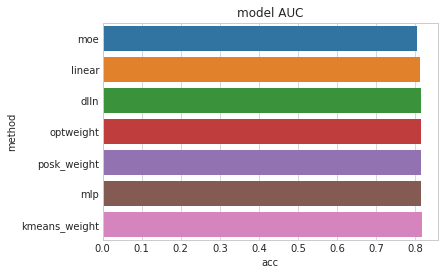

In [51]:
sns.set_style("whitegrid")
sns.barplot(x='acc', y='method', data=res)
plt.title('model %s' % ('accuracy' if dataname != 'mimic2' else 'AUC'))
plt.show()

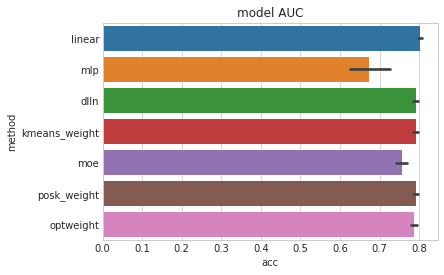

In [42]:
sns.set_style("whitegrid")
sns.barplot(x='acc', y='method', data=df)
plt.title('model %s' % ('accuracy' if dataname != 'mimic2' else 'AUC'))
plt.show()

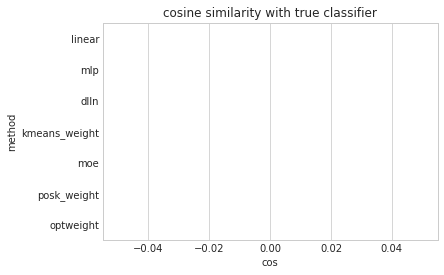

In [397]:
sns.barplot(x='cos', y='method', data=df)
plt.title('cosine similarity with true classifier')
plt.show()

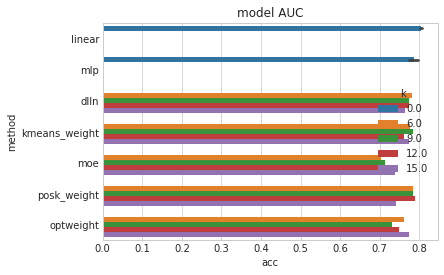

In [389]:
sns.barplot(x='acc', y='method', hue='k', data=df)
plt.title('model %s' % ('accuracy' if dataname != 'mimic2' else 'AUC'))
plt.show()

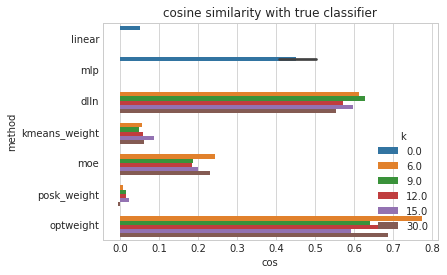

In [362]:
sns.barplot(x='cos', y='method', hue='k', data=df)
plt.title('cosine similarity with true classifier')
plt.show()

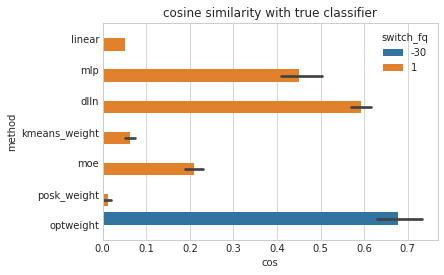

In [363]:
sns.barplot(x='cos', y='method', hue='switch_fq', data=df)
plt.title('cosine similarity with true classifier')
plt.show()

In [303]:
sns.factorplot(x='method', y='acc', hue='alpha', data=df[df['k']==17], 
               legend=False, kind='bar')
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.title('model %s' % ('accuracy' if dataname != 'mimic2' else 'AUC'))
plt.show()

sns.factorplot(x='method', y='cos', hue='alpha', data=df[df['k']==17], 
              kind='bar', legend=False)
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.title('model cosine')
plt.show()

ValueError: min() arg is an empty sequence

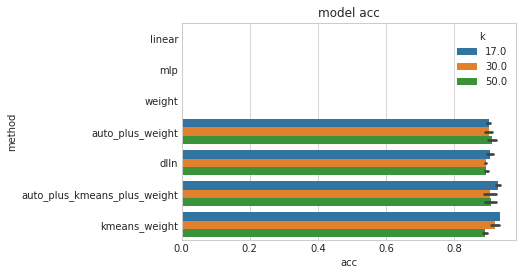

In [73]:
criteria = (df['alpha'] == -0.01) | (df['alpha'].isnull())
sns.barplot(x='acc', y='method', hue='k', data=df[criteria])
plt.title('model %s' % ('accuracy' if dataname != 'mimic2' else 'AUC'))
plt.show()

# debug realdata

In [322]:
train_data, val_data, _, _, ndim, _ = loadData('mimic2')

In [323]:
for x, y in train_data:
    print(x)
    print(y)
    break


-3.5892e-01 -3.7435e-01 -3.5354e-01  ...   2.5478e-01  7.4482e-01 -1.3716e-01
-1.2489e-03 -2.0662e-03 -4.2071e-03  ...  -1.4028e+00 -1.1285e+00  9.9196e-01
-1.2489e-03 -2.0662e-03 -4.2071e-03  ...  -1.9730e-01  1.0784e-01  1.7795e-01
                ...                   ⋱                   ...                
-1.2489e-03 -2.0662e-03 -4.2071e-03  ...  -1.0805e-02 -1.6012e-02 -1.1090e-01
-1.2489e-03 -2.0662e-03 -4.2071e-03  ...   1.7617e+00  6.0550e-01  9.3944e-01
-6.2234e-02 -1.0039e-01 -2.1252e-01  ...  -8.7541e-01 -1.3942e+00  3.9986e+00
[torch.FloatTensor of size 1000x130]


-1
-1
-1
⋮ 
 1
-1
 1
[torch.LongTensor of size 1000]



In [325]:
m = Mimic2()

In [326]:
m.ytrain.sum() / m.ytrain.shape[0]

0.13866666666666666